In [1]:
import numpy as np
import pandas as pd

import sklearn.neighbors as neighbors

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.render.frame as frame

import images
import subprocess

In [2]:
catalogs = []
catalog_tag = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_{:03d}.fits'
for i in np.arange(100):
    fname = catalog_tag.format(i)
    data = fio.read(fname)
    catalog_cluster = data[data['LOC'] == 1]
    catalog_field = data[data['LOC'] == 0]
    catalog = np.hstack((catalog_cluster, catalog_field))
    catalog['G1'] = 0.3
    catalog['G2'] = -0.2
    catalogs.append(catalog)

In [4]:
frs = []
shears = []
success = []
shears_error = []
mags = []
for i, catalog in enumerate(catalogs[:10]):
    name = 'canvas_{:03d}'.format(i)
    print(name)
    fr = frame.Frame(catalog, name=name, noise_std=4)
    fr.render()
    fr.extract()
    fr.ksb()
    frs.append(fr)
    
    shears.append(fr.sc.shears)
    success.append(fr.sc.success)
    shears_error.append(fr.sc.shears_error)
    mags.append(fr.scat["MAG_AUTO"])
    

canvas_000
starting xshear calculations in 100 processes
canvas_001
starting xshear calculations in 100 processes
canvas_002
starting xshear calculations in 100 processes
canvas_003
starting xshear calculations in 100 processes
canvas_004
starting xshear calculations in 100 processes
canvas_005
starting xshear calculations in 100 processes
canvas_006
starting xshear calculations in 100 processes
canvas_007
starting xshear calculations in 100 processes
canvas_008
starting xshear calculations in 100 processes
canvas_009
starting xshear calculations in 100 processes


In [42]:
_shears = np.concatenate(shears)
_shears_error = np.concatenate(shears_error)
_mags = np.concatenate(mags)
_success = np.concatenate(success)

In [26]:
_shears.shape

(92667, 2)

In [27]:
_shears_error.shape

(92667,)

In [28]:
_mags.shape

(92667,)

In [29]:
_success.shape

(92667,)

In [30]:
_mags.shape

(92667,)

In [43]:
_mags[_success]

array([21.92354 , 20.60128 , 23.664474, ..., 24.469463, 24.014368,
       24.350918], dtype=float32)

In [76]:
all_shears_error

array([0.051892708986997604, 0.01374006737023592, 0.23508350551128387,
       ..., None, 0.22236506640911102, 4.413488388061523], dtype=object)

In [101]:
ii1 = (all_mags[all_success] > 20) & (all_mags[all_success] < 22.5)
ii2 = all_shears_error[all_success] < 0.1
ii = ii1 * ii2

# all_shears[ii][all_success[ii]][ii2].mean(axis=0)

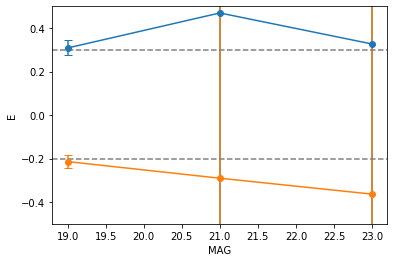

In [50]:
maglims = ((18, 20), (20, 22), (22, 24))
all_shears = np.concatenate(shears)
all_shears_error = np.concatenate(shears_error)
all_mags = np.concatenate(mags)
all_success = np.concatenate(success)
fig = plt.figure()
ax = fig.add_subplot(111)

xvals = (19, 21, 23)
yvals1 = []
yvals2 = []
errs1 = []
errs2 = []
for lims in maglims:

    ii = all_shears_error[all_success] < 0.1
    _mags = all_mags[all_success][ii]

    ii2 = (_mags > lims[0]) & (_mags < lims[1])
    
    yvals1.append(all_shears[all_success][ii][ii2].mean(axis=0)[0])
    yvals2.append(all_shears[all_success][ii][ii2].mean(axis=0)[1])
    errs1.append(all_shears[all_success][ii][ii2].std(axis=0)[0])
    errs2.append(all_shears[all_success][ii][ii2].std(axis=0)[1])

    
ax.errorbar(xvals, yvals1, errs1, marker="o", capsize=4)
ax.errorbar(xvals, yvals2, errs2, marker="o", capsize=4)
                            
ax.axhline(0.3, ls="--", color="gray") 
ax.axhline(-0.2, ls="--", color="gray") 
ax.set_xlabel("MAG")
ax.set_ylabel("E")
ax.set_ylim(-0.5, 0.5)
fig.savefig("All_shear_mag_fig.png", dpi=300)
    